In [1]:
#Ignore if Libaries are already installed
!pip install -U numpy --user
!pip install -U sklearn --user
!pip install -U torch --user
!pip install -U pandas --user
!pip install -U matplotlib --user
!pip install -U mne --user

In [2]:
# ignore most of these imports this notebook used to do sth else
import numpy as np

from sklearn.metrics import roc_auc_score, precision_score, recall_score, accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
import torch.nn.functional as F
from torch.utils.data import Dataset

import pandas as pd

from matplotlib import pyplot

import mne
from mne.io import concatenate_raws, read_raw_fif
import mne.viz

from os import walk

In [3]:
# link to dataset: https://zenodo.org/record/197404#.X1Li7HlKiUl
# there are 27 participants in the trial, and each file name contains the ID of its participant
participant_prefix = ['{:02}_'.format(x) for x in range(1, 38)]
print(participant_prefix)

['01_', '02_', '03_', '04_', '05_', '06_', '07_', '08_', '09_', '10_', '11_', '12_', '13_', '14_', '15_', '16_', '17_', '18_', '19_', '20_', '21_', '22_', '23_', '24_', '25_', '26_', '27_', '28_', '29_', '30_', '31_', '32_', '33_', '34_', '35_', '36_', '37_']


In [4]:
files = []
# study1_eeg is a folder with a bunch of csv files, each file partaining to a different trial
path = 'EEG/'
for prefix in participant_prefix:
    for (dirpath, dirnames, filenames) in walk(path):
        # gets the file paths and adds them to a list
        new_names = [dirpath+f for f in filenames if (prefix in f)]
        files.extend(new_names)
        break


In [5]:
tmp = np.loadtxt(files[0], delimiter=',', skiprows = 1, usecols=np.arange(1,13), dtype = np.float16)
# finds the number of channels from the shape of the file (channels X timepoints)

#TODO: Remove the resize
tmp = np.transpose(tmp)

#tmp = np.append(tmp, 200 * np.array([[]]), axis=0)
#tmp = np.resize(tmp,(256, tmp.shape[1]))

print(tmp.shape)
#print(tmp[200])
print(tmp)


(12, 574700)
[[   41.6    86.4    72.2 ...  -670.   -643.   -609.5]
 [   66.6     9.7   -50.4 ...  -540.   -510.2  -473. ]
 [   87.8    64.3    10.9 ... -1087.  -1059.  -1023.5]
 ...
 [ -107.9  -154.8  -170.2 ...  -756.   -730.5  -696. ]
 [ -132.4  -148.2  -149.4 ...  -745.5  -709.   -666. ]
 [ -199.2  -206.5  -186.1 ...  -513.5  -475.2  -431.8]]


In [6]:
def loadFile(trial,participant_data):
     # each iteration loads data from a trial
    print(trial)
    new_data = np.loadtxt(files[trial], delimiter=',', skiprows = 1, usecols=np.arange(1,13), dtype = np.float16)
    new_data = np.transpose(new_data)
    new_data = np.resize(new_data,(n_channels,n_times))
    if trial == 0:
        # just reassuring again that is the right shape
        print('n_channels, n_times: ' + str(new_data.shape))
    #new_data = new_data.astype(float32)
    participant_data[trial] = new_data

In [7]:
from concurrent.futures import ThreadPoolExecutor
import multiprocessing as mp
from threading import Thread 
from multiprocessing import Pool


n_channels = tmp.shape[0]
n_times = tmp.shape[1]

# makes an array large enough to hold all of the data
arr = mp.Array('d', int(len(files)) * n_channels * n_times)
participant_data = np.frombuffer(arr.get_obj(), 'd')
participant_data = np.resize(participant_data,(int(len(files)), n_channels,n_times))
print(participant_data.shape)


for trial in range(0,len(files)):
    # each iteration loads data from a trial
    loadFile(trial,participant_data)
#     with Pool(processes=5) as pool:
#         pool.map(loadFile, (trial,participant_data)) 

print(participant_data[0])
print('Number of epochs: ' + str(participant_data.shape))

(30, 12, 574700)
0
n_channels, n_times: (12, 574700)
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
[[   41.59375      86.375        72.1875    ...  -670.
   -643.         -609.5      ]
 [   66.625         9.703125    -50.40625   ...  -540.
   -510.25       -473.       ]
 [   87.8125       64.3125       10.8984375 ... -1087.
  -1059.        -1023.5      ]
 ...
 [ -107.875      -154.75       -170.25      ...  -756.
   -730.5        -696.       ]
 [ -132.375      -148.25       -149.375     ...  -745.5
   -709.         -666.       ]
 [ -199.25       -206.5        -186.125     ...  -513.5
   -475.25       -431.75     ]]
Number of epochs: (30, 12, 574700)


In [8]:
# gets the ID of the events from the names of each file
epochs_events = []
for f in files:
    res = f.split('_')
    res[-1] = res[-1].split('.')
    epochs_events.append(res[-1][0])

In [9]:
unique_events = list(set(epochs_events))
print(unique_events)
unique_events = sorted(unique_events)
print(unique_events)
unique_events_num = [i for i in range(len(unique_events))]

# formats a numpy array to work with the epochs object 
# format = (event #, prev event class, current event class)
epoch_events_num = np.ndarray((len(epochs_events),3),int)

for i in range(len(epochs_events)):
    for j in range(len(unique_events)):
        if epochs_events[i] == unique_events[j]:
            epoch_events_num[i,2] = unique_events_num[j]
            if i > 0:
                epoch_events_num[i,1] = epoch_events_num[i-1,2]
            else:
                epoch_events_num[i,1] = unique_events_num[j]
        epoch_events_num[i,0] = i
        
# associates each event with an index
event_id = {}
for i in range(len(unique_events)):
    event_id[unique_events[i]] = unique_events_num[i]


['Unaware', 'Aware']
['Aware', 'Unaware']


Number of channels: 256
Creating RawArray with float64 data, n_channels=256, n_times=1
    Range : 0 ... 0 =      0.000 ...     0.000 secs
Ready.


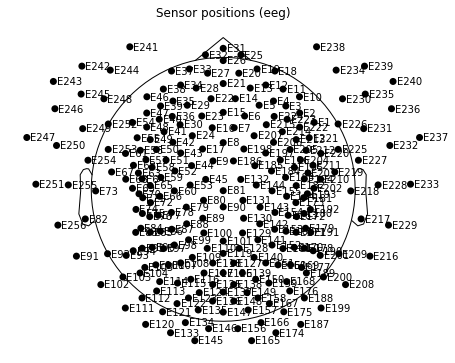

Number of channels after removing the fudicials: 12


In [10]:
%matplotlib inline

# data was taken with a biosemi eeg device, so biosemi64 is passed into the function
montage = mne.channels.make_standard_montage('GSN-HydroCel-256') 
print('Number of channels: ' + str(len(montage.ch_names)))
montage.plot(show_names=True)
n_channels = 256

# there are 64 channels in the cap but 67 in the montage, three are just there for
# reference (fiducial) and need to be removed
#fiducials = ['Nz', 'LPA', 'RPA']

#ch_names = montage.ch_names
ch_names = ['E86','E96','E97','E109','E116','E119','E126','E140','E150','E161','E162','E170']

#ch_names = [x for x in ch_names if x not in fiducials]
print('Number of channels after removing the fudicials: '+ str(len(ch_names)))
# Specify ampling rate
sfreq = 256  # Hz

In [11]:
# creates an mne info instance with the different info we've collected
epochs_info = mne.create_info(ch_names, sfreq, ch_types='eeg')

# creates an mne epochs object with the info and the data
epochs = mne.EpochsArray(data=participant_data, info=epochs_info, events=epoch_events_num, event_id=event_id)
epochs.set_montage(montage)

# drops bad epochs, doesn't actually do anything rn
epochs.drop_bad()

epochs.info

Not setting metadata
Not setting metadata
30 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped


<Info | 8 non-empty values
 bads: []
 ch_names: E86, E96, E97, E109, E116, E119, E126, E140, E150, E161, E162, E170
 chs: 12 EEG
 custom_ref_applied: False
 dig: 15 items (3 Cardinal, 12 EEG)
 highpass: 0.0 Hz
 lowpass: 128.0 Hz
 meas_date: unspecified
 nchan: 12
 projs: []
 sfreq: 256.0 Hz
>

In [12]:
# save the epochs as a .fif
epochs.save('EEG/epochdata/master.fif', verbose='error', overwrite=True)

In [13]:
# example of loading the data
data_file = 'EEG/epochdata/master.fif'

# Read the EEG epochs:
epochs = mne.read_epochs(data_file, verbose='error')
print(epochs)

<EpochsFIF |  30 events (all good), 0 - 2244.92 sec, baseline off, ~1.54 GB, data loaded,
 'Aware': 17
 'Unaware': 13>
